In [ ]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass

import warnings

warnings.warn = warn

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os
import joblib
from datetime import datetime

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

In [39]:
if (os.path.exists("../../data/train_test_validate_data/train_test_data.csv")):
    data = pd.read_csv("../../data/train_test_validate_data/train_test_data.csv")
else:
    ownership_df_class = pd.read_csv("../../data/final_data/final_ownership_data.csv")
    sales_df_reg = pd.read_csv("../../data/final_data/final_sales_data.csv")

    ownership_df_class = ownership_df_class.drop(columns=['Unnamed: 0', '_c0'])
    sales_df_reg = sales_df_reg.drop(columns=['Unnamed: 0', '_c0'])
    sales_df_reg = sales_df_reg[['Annual_Income', 'Price']]


    def find_closest_income_match(target_income, reference_df):
        closest_income_idx = (reference_df['Annual_Income'] - target_income).abs().idxmin()
        return reference_df.loc[closest_income_idx, 'Price']


    ownership_df_class['Price'] = ownership_df_class.apply(
        lambda row: find_closest_income_match(row['Annual_Income'], sales_df_reg)
        if row['Car'] == 'Yes'
        else 0,
        axis=1
    )

    ownership_sales = ownership_df_class.__deepcopy__()
    ownership_sales.to_csv(path_or_buf="../../data/train_test_validate_data/train_test_data.csv")
    data = pd.read_csv("../../data/train_test_validate_data/train_test_data.csv")
    
data

,Unnamed: 0,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children,Price
0,0,Teacher,52800.0,750,10,Good,Yes,2,57000
1,1,Engineer,79200.0,800,8,Good,Yes,1,15000
2,2,Nurse,33000.0,650,5,Fair,No,0,0
3,3,Doctor,105600.0,900,12,Excellent,Yes,3,26001
4,4,Businessman,132000.0,700,15,Good,Yes,2,26001
...,...,...,...,...,...,...,...,...,...
391,391,Customer Support,4620.0,640,3,Stable,No,1,0
392,392,Dental Hygienist,6336.0,670,4,Stable,Yes,2,19000
393,393,Project Manager,9240.0,730,5,Stable,Yes,0,39000
394,394,Medical Assistant,4620.0,640,3,Stable,No,1,0


In [40]:
data = data.drop(columns=['Unnamed: 0', 'Price'])
data['Car'] = data['Car'].replace({'Yes': 1, 'No': 0})
label_mapping = {
    'Unknown': 0,
    'Poor': 1,
    'Unstable': 2,
    'Fair': 3,
    'Stable': 4,
    'Good': 5,
    'Excellent': 6
}
data['Finance_Status'] = data['Finance_Status'].replace(label_mapping)
data

,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children
0,Teacher,52800.0,750,10,5,1,2
1,Engineer,79200.0,800,8,5,1,1
2,Nurse,33000.0,650,5,3,0,0
3,Doctor,105600.0,900,12,6,1,3
4,Businessman,132000.0,700,15,5,1,2
...,...,...,...,...,...,...,...
391,Customer Support,4620.0,640,3,4,0,1
392,Dental Hygienist,6336.0,670,4,4,1,2
393,Project Manager,9240.0,730,5,4,1,0
394,Medical Assistant,4620.0,640,3,4,0,1


In [41]:
data = data.where((data['Annual_Income'] < 45000)).dropna(axis=0)
data

,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children
2,Nurse,33000.0,650.0,5.0,3.0,0.0,0.0
7,Nurse,26400.0,600.0,3.0,1.0,0.0,-1.0
10,Engineer,7920.0,700.0,3.0,5.0,1.0,-1.0
11,Salesperson,3960.0,600.0,1.0,3.0,0.0,-1.0
12,Teacher,5280.0,750.0,5.0,6.0,1.0,-1.0
...,...,...,...,...,...,...,...
391,Customer Support,4620.0,640.0,3.0,4.0,0.0,1.0
392,Dental Hygienist,6336.0,670.0,4.0,4.0,1.0,2.0
393,Project Manager,9240.0,730.0,5.0,4.0,1.0,0.0
394,Medical Assistant,4620.0,640.0,3.0,4.0,0.0,1.0


In [42]:
data['Annual_Income_Credit_Score'] = data['Annual_Income'] / data['Credit_Score']
data['Annual_Income_Years_Employment'] = data['Annual_Income'] / data['Years_of_Employment']
data['Years_Employment_Credit_Score'] = data['Credit_Score'] / data['Years_of_Employment'] 
data

,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children,Annual_Income_Credit_Score,Annual_Income_Years_Employment,Years_Employment_Credit_Score
2,Nurse,33000.0,650.0,5.0,3.0,0.0,0.0,50.769231,6600.0,130.000000
7,Nurse,26400.0,600.0,3.0,1.0,0.0,-1.0,44.000000,8800.0,200.000000
10,Engineer,7920.0,700.0,3.0,5.0,1.0,-1.0,11.314286,2640.0,233.333333
11,Salesperson,3960.0,600.0,1.0,3.0,0.0,-1.0,6.600000,3960.0,600.000000
12,Teacher,5280.0,750.0,5.0,6.0,1.0,-1.0,7.040000,1056.0,150.000000
...,...,...,...,...,...,...,...,...,...,...
391,Customer Support,4620.0,640.0,3.0,4.0,0.0,1.0,7.218750,1540.0,213.333333
392,Dental Hygienist,6336.0,670.0,4.0,4.0,1.0,2.0,9.456716,1584.0,167.500000
393,Project Manager,9240.0,730.0,5.0,4.0,1.0,0.0,12.657534,1848.0,146.000000
394,Medical Assistant,4620.0,640.0,3.0,4.0,0.0,1.0,7.218750,1540.0,213.333333


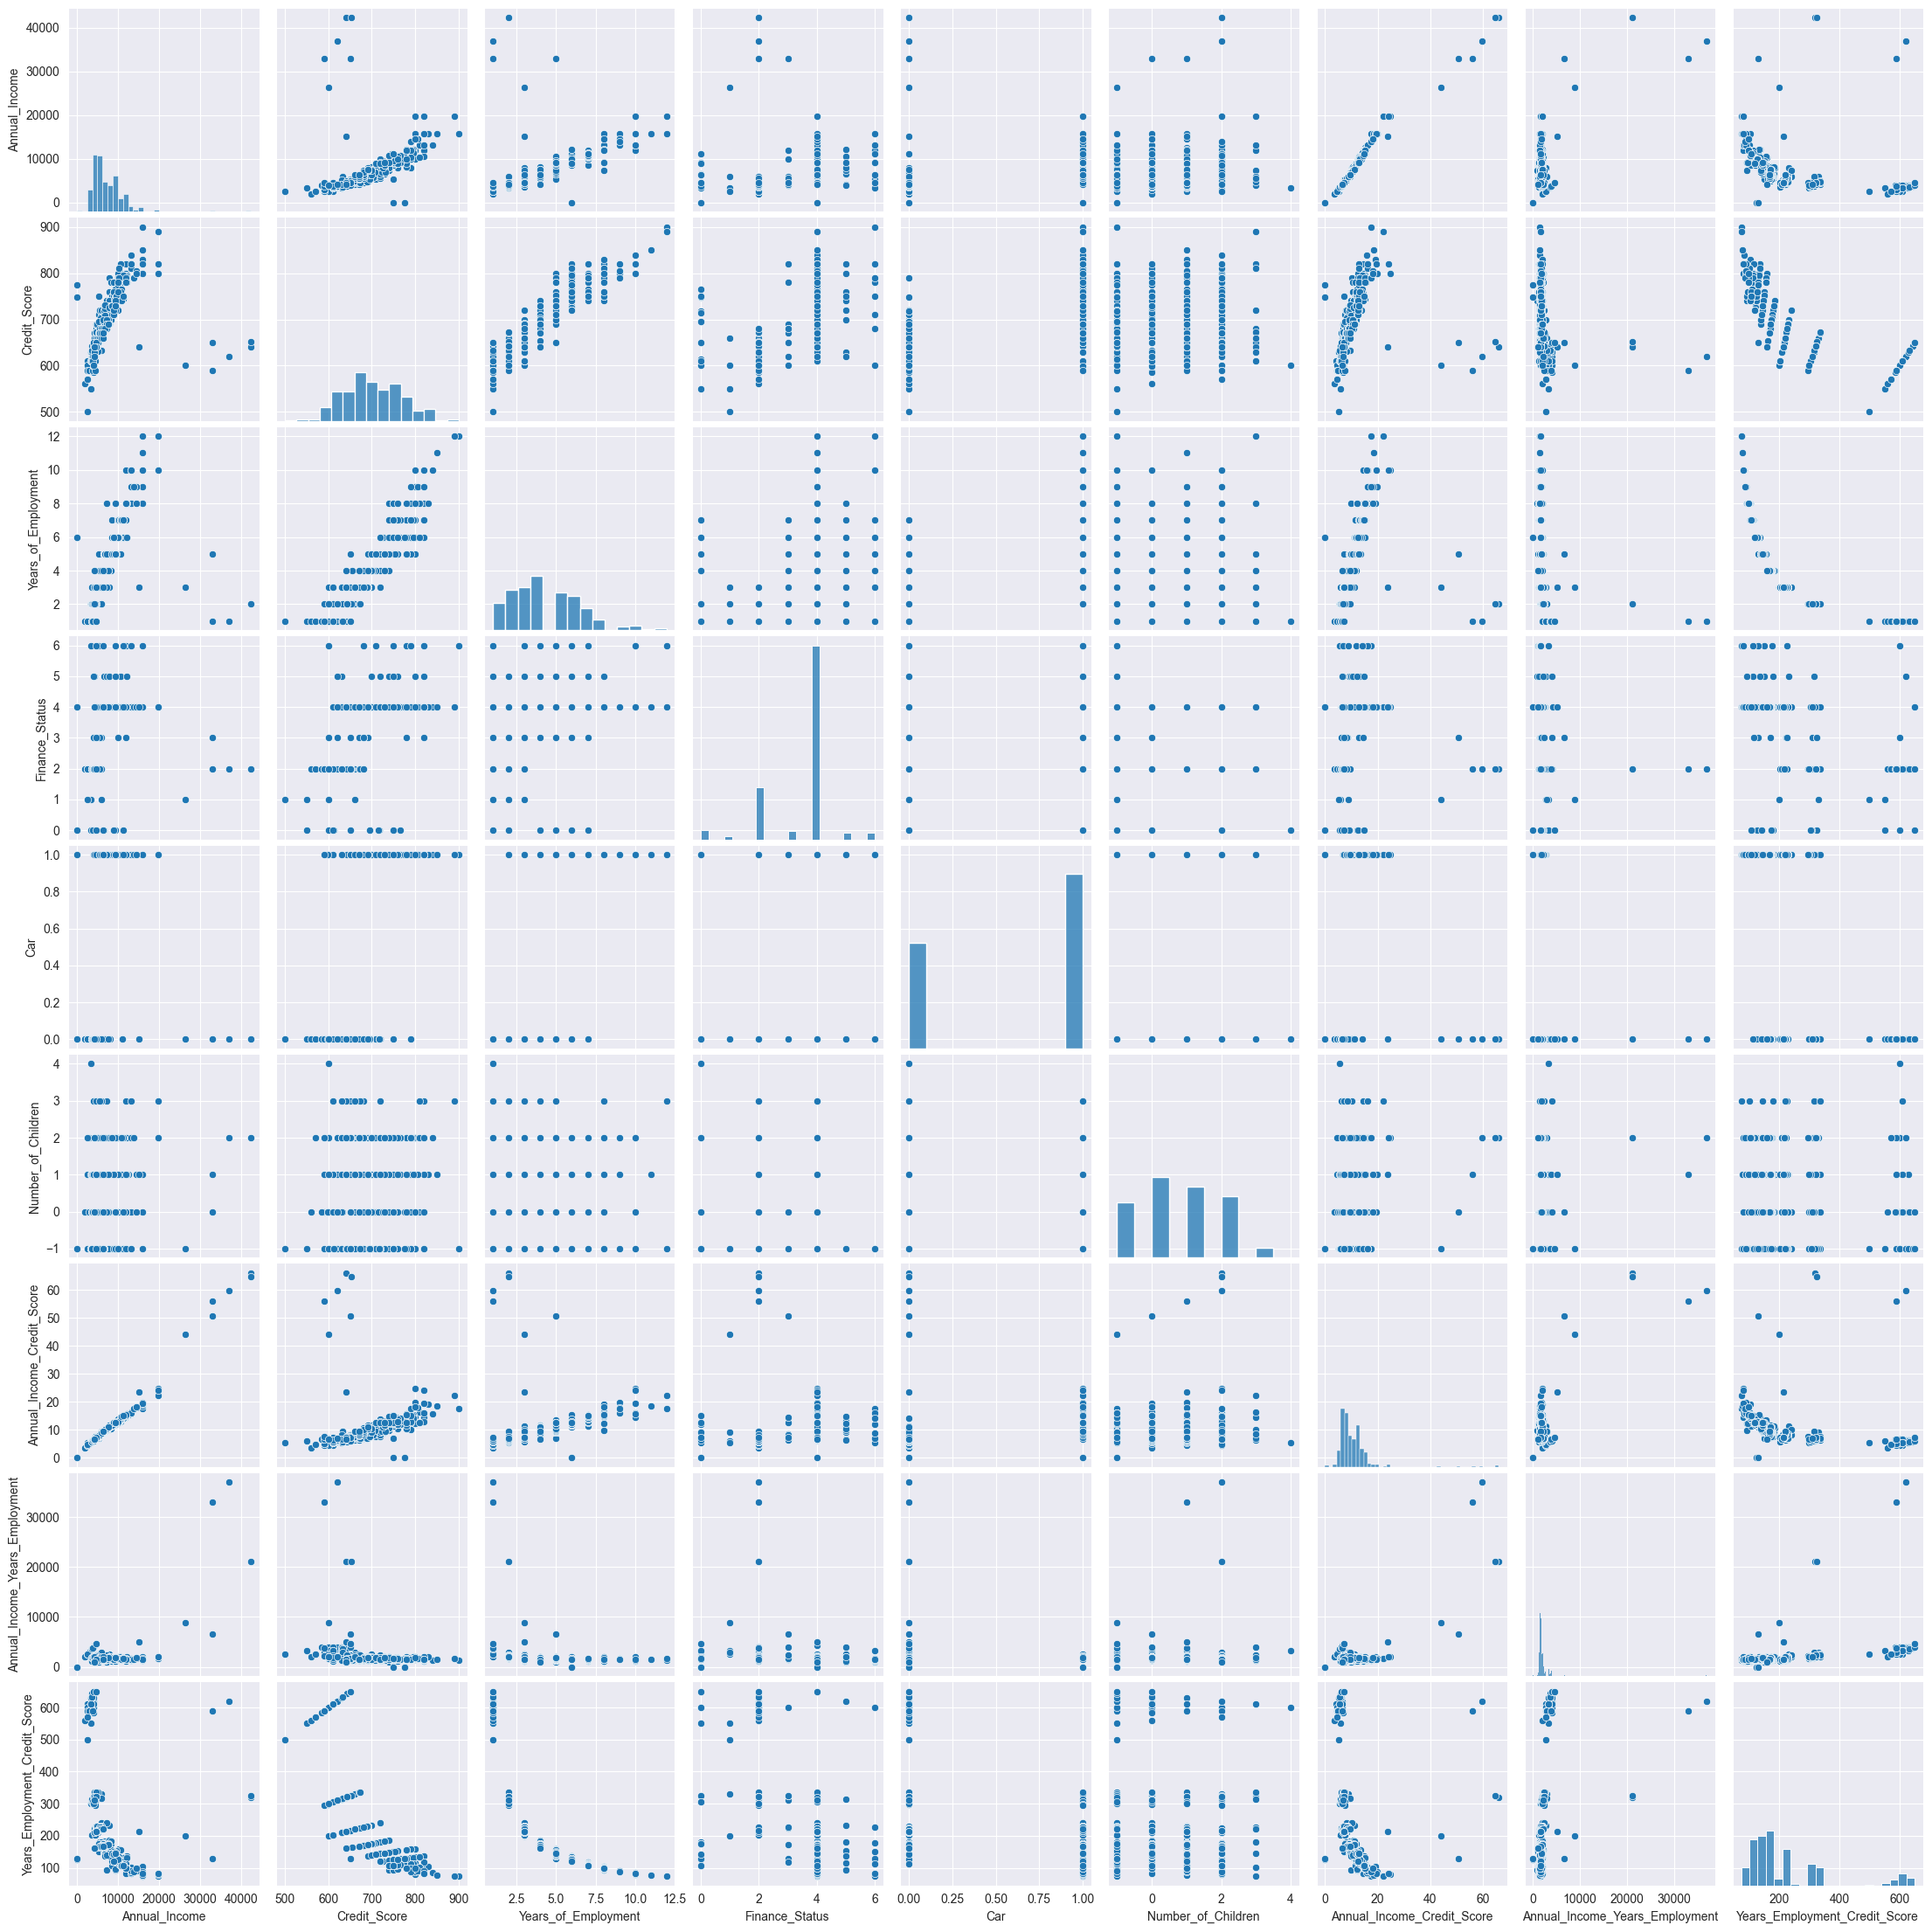

In [43]:
pp_data = data.__deepcopy__()
pp_data = pp_data.drop(columns=['Occupation'])
sns.pairplot(pp_data)

In [44]:
data_enc = pd.get_dummies(data, columns=['Occupation'], drop_first=True, dtype=float)
data_enc

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children,Annual_Income_Credit_Score,Annual_Income_Years_Employment,Years_Employment_Credit_Score,Occupation_Account Manager,...,Occupation_Software Dev,Occupation_Software Developer,Occupation_Software Engineer,Occupation_Teacher,Occupation_Veterinarian,Occupation_Veterinarian Technician,Occupation_Waiter/Waitress,Occupation_Web Designer,Occupation_Web Developer,Occupation_Writer
2,33000.0,650.0,5.0,3.0,0.0,0.0,50.769231,6600.0,130.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,26400.0,600.0,3.0,1.0,0.0,-1.0,44.000000,8800.0,200.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,7920.0,700.0,3.0,5.0,1.0,-1.0,11.314286,2640.0,233.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,3960.0,600.0,1.0,3.0,0.0,-1.0,6.600000,3960.0,600.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5280.0,750.0,5.0,6.0,1.0,-1.0,7.040000,1056.0,150.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,4620.0,640.0,3.0,4.0,0.0,1.0,7.218750,1540.0,213.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,6336.0,670.0,4.0,4.0,1.0,2.0,9.456716,1584.0,167.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393,9240.0,730.0,5.0,4.0,1.0,0.0,12.657534,1848.0,146.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,4620.0,640.0,3.0,4.0,0.0,1.0,7.218750,1540.0,213.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
Y = data_enc['Car']
X = data_enc.drop(columns=['Car'])

In [46]:
def create_model_pipelines():
    """Create dictionary of model pipelines with their parameter grids"""

    models = {
        'Logistic_Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=42))
            ]),
            'params': {
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'model__penalty': ['l1', 'l2'],
                'model__solver': ['liblinear', 'saga']
            }
        },

        'Decision_Tree': {
            'pipeline': Pipeline([
                ('model', DecisionTreeClassifier(random_state=42))
            ]),
            'params': {
                'model__max_depth': [3, 5, 7, 10],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4],
                'model__criterion': ['gini', 'entropy']
            }
        },

        'Random_Forest': {
            'pipeline': Pipeline([
                ('model', RandomForestClassifier(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [5, 7, 10],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4],
                'model__max_features': ['sqrt', 'log2']
            }
        },

        'XGBoost': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', XGBClassifier(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [3, 5, 7],
                'model__learning_rate': [0.01, 0.1, 0.3],
                'model__min_child_weight': [1, 3, 5],
                'model__subsample': [0.8, 0.9, 1.0],
                'model__colsample_bytree': [0.8, 0.9, 1.0]
            }
        },

        'Gradient_Boosting': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [100, 200, 300],
                'model__learning_rate': [0.01, 0.1, 0.3],
                'model__max_depth': [3, 5, 7],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            }
        },

        'KNN': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())
            ]),
            'params': {
                'model__n_neighbors': [3, 5, 7, 9, 11],
                'model__weights': ['uniform', 'distance'],
                'model__metric': ['euclidean', 'manhattan']
            }
        },

        'AdaBoost': {
            'pipeline': Pipeline([
                ('model', AdaBoostClassifier(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [50, 100, 200],
                'model__learning_rate': [0.01, 0.1, 1.0],
                'model__algorithm': ['SAMME', 'SAMME.R']
            }
        }
    }

    return models

def train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=5, accuracy_threshold=0.7):
    """
    Train models using GridSearchCV and evaluate their performance

    Parameters:
    X_train, X_test : feature matrices for train and test sets
    y_train, y_test : target vectors for train and test sets
    cv : number of cross-validation folds (default=5)
    accuracy_threshold : minimum accuracy score for models to be included in stacking
    """

    # Get model pipelines and their parameter grids
    models = create_model_pipelines()

    # Store results and best models
    results = []
    best_models = {}

    # Train and evaluate each model
    for name, model_info in models.items():
        print(f"\nTraining {name}...")

        # Create and train GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_info['pipeline'],
            param_grid=model_info['params'],
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)

        # Get the best model
        best_models[name] = grid_search.best_estimator_

        # Make predictions
        train_pred = grid_search.predict(X_train)
        test_pred = grid_search.predict(X_test)

        # Calculate metrics
        results.append({
            'Model': name,
            'Best Parameters': grid_search.best_params_,
            'Train Accuracy': accuracy_score(y_train, train_pred),
            'Test Accuracy': accuracy_score(y_test, test_pred),
            'Train Precision': precision_score(y_train, train_pred, average='weighted'),
            'Test Precision': precision_score(y_test, test_pred, average='weighted'),
            'Train Recall': recall_score(y_train, train_pred, average='weighted'),
            'Test Recall': recall_score(y_test, test_pred, average='weighted'),
            'Train F1': f1_score(y_train, train_pred, average='weighted'),
            'Test F1': f1_score(y_test, test_pred, average='weighted')
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Create stacking classifier from best performing models
    good_models = []
    for name, model in best_models.items():
        if results_df.loc[results_df['Model'] == name, 'Test Accuracy'].values[0] >= accuracy_threshold:
            good_models.append((name, model))

    if len(good_models) > 1:
        print(f"\nCreating Stacking Classifier with models that have accuracy >= {accuracy_threshold}:")
        for name, _ in good_models:
            print(f"- {name}")

        # Use LogisticRegression as final estimator
        stacking = StackingClassifier(
            estimators=good_models,
            final_estimator=LogisticRegression(),
            cv=5
        )

        # Train stacking classifier
        stacking.fit(X_train, y_train)

        # Add stacking classifier results
        y_train_pred = stacking.predict(X_train)
        y_test_pred = stacking.predict(X_test)

        results.append({
            'Model': 'Stacking_Classifier',
            'Best Parameters': {'estimators': [name for name, _ in good_models]},
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train Precision': precision_score(y_train, y_train_pred, average='weighted'),
            'Test Precision': precision_score(y_test, y_test_pred, average='weighted'),
            'Train Recall': recall_score(y_train, y_train_pred, average='weighted'),
            'Test Recall': recall_score(y_test, y_test_pred, average='weighted'),
            'Train F1': f1_score(y_train, y_train_pred, average='weighted'),
            'Test F1': f1_score(y_test, y_test_pred, average='weighted')
        })

        # Update results DataFrame
        results_df = pd.DataFrame(results)
        best_models['Stacking_Classifier'] = stacking

    return results_df, best_models

def get_best_model_results(results_df, best_models, X_test, y_test):
    """Print detailed results for the best performing model and save it"""

    # Find the best model based on test accuracy
    best_model_name = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Model']
    best_model = best_models[best_model_name]

    # Make predictions on test data
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print("\nBest Model:", best_model_name)
    print("\nBest Model Parameters:")
    print(results_df.loc[results_df['Model'] == best_model_name, 'Best Parameters'].values[0])

    print("\nBest Model Performance on Test Data:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save the model
    model_dir = '../../models/'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"\nCreated directory: {model_dir}")

    # Create filename with timestamp and performance metric
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"best_model_{best_model_name}_ACC_{test_accuracy:.4f}_{timestamp}.joblib"
    model_path = os.path.join(model_dir, filename)

    # Save the model
    joblib.dump(best_model, model_path)
    print(f"\nBest model saved to: {model_path}")

    # Save model info to a text file
    info_filename = f"model_info_{timestamp}.txt"
    info_path = os.path.join(model_dir, info_filename)

    with open(info_path, 'w') as f:
        f.write(f"Model Name: {best_model_name}\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        f.write("Performance Metrics:\n")
        f.write(f"Accuracy: {test_accuracy:.4f}\n")
        f.write(f"Precision: {test_precision:.4f}\n")
        f.write(f"Recall: {test_recall:.4f}\n")
        f.write(f"F1 Score: {test_f1:.4f}\n\n")
        f.write("Model Parameters:\n")
        f.write(str(results_df.loc[results_df['Model'] == best_model_name, 'Best Parameters'].values[0]))

    print(f"Model information saved to: {info_path}")

    return best_model

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

results_df, best_models = train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=5, accuracy_threshold=0.7)

print("\nAll Models Comparison:")
print(results_df[['Model', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']])

best_model = get_best_model_results(results_df, best_models, X_test, y_test)

predictions = best_model.predict(X_test)


Training Logistic_Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Training Decision_Tree...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Training Random_Forest...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Training XGBoost...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Training Gradient_Boosting...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Training KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Training AdaBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Creating Stacking Classifier with models that have accuracy >= 0.7:
- Logistic_Regression
- Decision_Tree
- Random_Forest
- XGBoost
- Gradient_Boosting
- KNN
- AdaBoost

All Models Comparison:
                 Model  Test Accuracy  Test Precision  Test Recall   Test F1
0  Logistic_Regression       0.714286        0.778040     0.714286  0.700761
1        Decision_Tree       0.87013